# Assignment 2 -  Extended Kalman filter and Unscented Kalman filter


- **Topic:** Desiging an EKF and UKF to estimate the position using magnetic field information
- **Assessment:** The assignment will go through a pass/fail check.


- **Deadline:**  07-03-2025, 17:00
- **Submitting: SUBMIT ONLY `assignment2_groupNumber.ipynb` TO BRIGHTSPACE**, where groupNumber is your groupnumber



## Instructions
**Installation:** The implementation is tested with python 3.9.12 and packages including
-   numpy version: 1.26.4
-   scipy version: 1.13.0
-   matplotlib version: 3.5.1


Other (not too old or new) versions will probabily also work.

You may not use other packages for algorithm-related calculations.
You only need to complete (and submit) this file.
Please do not change the additional files `GP.py`, `helper.py` and `linAlg.py` and the dictionary `modelParameters` as this might result in breaking the assignment.



## AI Related Policy
We strongly discourage you to use AI tools for implementation assistance. It is your understanding of the problem that is tested in the final exam.


## Information
Please fill in your group number, names and student numbers in the cell below.

<!-- first EKF and then UKF, very similar to normal KF-->

In [1]:
''' YOUR ANSWER HERE '''
groupNumber = 17

STUDENT_1_NAME = "Tom Lijding"
STUDENT_1_STUDENT_NUMBER = "6318037"

STUDENT_2_NAME = "Tjalle Aalbers"
STUDENT_2_STUDENT_NUMBER = "5374774"

# raise NotImplementedError()

## Objectives

#### Goal

The goal of this assignment is to estimate the position $ \mathbf{p}_t $ of an agent, the same as assignment 1, but using different algorithmns. The agent moves in an indoor environment and gets information about its approximate change in position $ \Delta \mathbf{p}_t $ at every time-step. To model this, you may assume a linear dynamic model of the form:
$$\mathbf{p}_{t + 1} = \mathbf{p}_t + \Delta \mathbf{p}_{t+1} + \mathbf{w}_{t+1}$$

Where:

- $\mathbf{p}_t$ is a 3-dimensional position vector of the agent at time $t$. 

- $\Delta \mathbf{p}_t$ is the change in positon.

- $\mathbf{w}_t \sim \mathcal{N}(0_{3 \times 1}, \mathbf{Q})$ is Gaussian white noise.

- $ \mathbf{Q} \in \mathbb{R}^{3 \times 3} $ is the covariance of the process noise.

Since the information of the change in position $ \Delta \mathbf{p}_t$ contains errors, the position estimates from the dynamic model will drift. This means that over time, the agent will lose track of where it actually is. To remedy this, the agent is carrying a magnetometer, and has a map of the magnetic field. The magnetometer samples a measurement of the magnetic field $\mathbf{y}_t$ at every position $\mathbf{p}_t$. The map of the magnetic field is modeled by a non-linear function: a reduced rank Gaussian process (you do not need to understand, model or change the GP model, only to call the function evaluation). This results in the non-linear measurement model:
$$ \mathbf{y}_t = f(\mathbf{p}_t) + \mathbf{v}_t $$

Where:

- $\mathbf{y}_t$ is a 3-dimensional measurement vector of the magnetic field at time-step $t$.

- $f(\cdot)$ is the reduced rank Gaussian process function.

- $\mathbf{v}_t \sim \mathcal{N}(0_{3 \times 1}, \mathbf{R})$ is Gaussian white noise.

- $ \mathbf{R} \in \mathbb{R}^{3 \times 3} $ is the covariance of the measurement noise.


#### First load in the data
To start, first load in the data below
All variables you will use are numpy arrays, where
- `magnetometerMeasurements` $\in \mathbb{R}^{3 \times \text{T}}$ is a numpy array containing the magnetometer measurements
- `magnetometerInitialPosition` $\in \mathbb{R}^{3 \times 1}$ is a numpy array containing the initial position of the magnetometer
- `deltaMagnetometerPositions` $\in \mathbb{R}^{3 \times \text{T}}$ is a numpy array containing the change in position of the magnetometer

#### Warning
- Additionally you are provided with a dictionary modelParameters which is used in creating magnetic field maps. DO NOT CHANGE dictionary as this might break the assignment. To create the EKF and UKF you DO NOT need this dictionary.

In [ ]:
''' DO NOT CHANGE THE CODE BELOW '''
import numpy as np
import matplotlib.pyplot as plt

import GP as GP
import linAlg as linAlg
import helper as helper
np.random.seed(groupNumber)

(magnetometerMeasurements, 
 magnetometerInitialPosition, 
 deltaMagnetometerPositions,
 modelParameters) = helper.initializeKalmanFilterAssignment(groupNumber % 29)


Same as the first assignment of particle filter, below, a function `helper.makeDeadReckoningPlots()` is given to plot the map of the magnetic field and the ground truth position of the path taken by the agent. The agent does not know this path, it only has access to its initial position, the change in position at every time-step and the magnetometer measurements. You can reuse the code for the plots.

Your first task it to use the agent's dynamic model to try and reconstruct the ground truth path. This is also known as dead reckoning and should be done using data stored in the variables `magnetometerInitialPosition` and `deltaMagnetometerPositions`. Save the agent's positions according to the dynamic model in the variable `deadReckoning` $\in \mathbb{R}^{3 \times \text{T}}$. Additionally, compare the magnetometer measurements with the map of the magnetic field. To achieve this, store the norm of the magnetic field at every time-step in the variable `magneticFieldNorm` $\in \mathbb{R}^{\text{T}}$.

This function should output two subfigures. Every subfigure includes the magnetic field map in the background. On the left the ground truth positions are plotted together with the dead reckoning positions. On the right, the magnetic field measurements are plotted with  the ground truth positions over the magnetic field map.

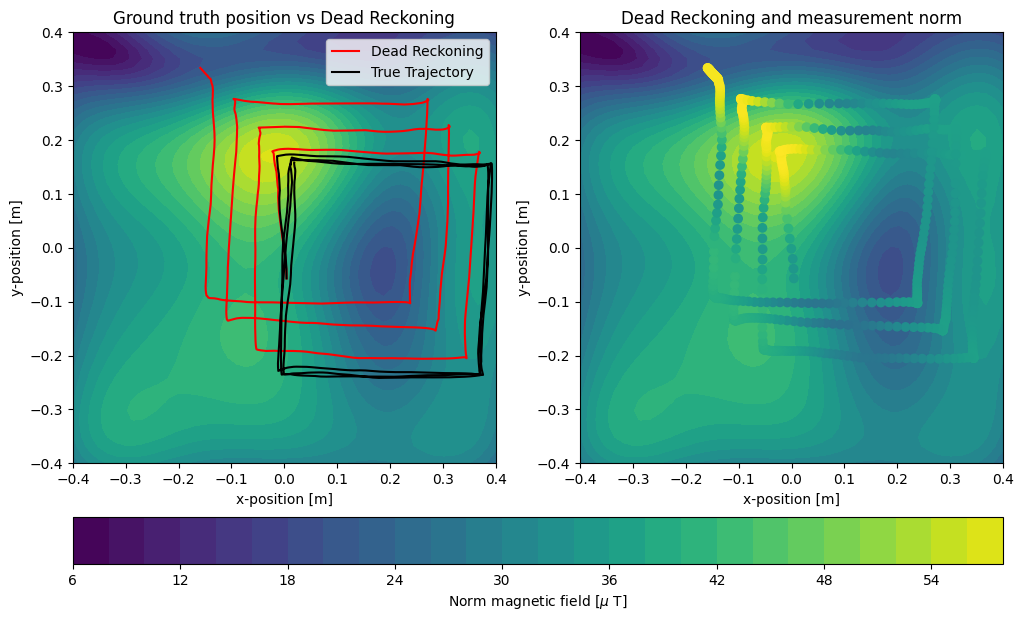

In [3]:
deadReckoning = np.zeros_like(deltaMagnetometerPositions)
deadReckoning[:, 0] = magnetometerInitialPosition.flatten() 

# Compute dead reckoning path
for t in range(1, deltaMagnetometerPositions.shape[1]):
    deadReckoning[:, t] = deadReckoning[:, t-1] + deltaMagnetometerPositions[:, t]
magneticFieldNorm = np.linalg.norm(magnetometerMeasurements, axis=0)

helper.makeDeadReckoningPlots(deadReckoning, magneticFieldNorm, modelParameters)

## EKF and UKF
To  use magnetometer measurements to reduce the positional drift observed in the figure above, besides PF in the previous lectures, you can also use EKF and UKF.

### EKF Implementation

You start from implementing EKF.  Your task is to fill in the following functions.

#### Task 1
Fill in the `dynamicUpdateEKF()` function according to the dynamic model given above. 

**Note:**
You do not have to change the inputs and outputs to the given functions.


In [4]:

def dynamicUpdateEKF(position, 
                   deltaPos, 
                   posCov, 
                   motionCovarianceEKF, 
                   modelParameters):
    ''' Dynamic update '''
    # First define the white noise of the dynamics, reshape it to be a 1d array instead of 0d
    gWhiteNoise = np.random.multivariate_normal(mean=np.zeros(3), cov=motionCovarianceEKF).T
    gWhiteNoise = np.reshape(gWhiteNoise,(3,1))
    # Define our new position as the former position, plus the delta position, plus the white noise
    position = position + deltaPos + gWhiteNoise

    # Define our F matrix by calculating the relative change in position caused by deltaPos, since each diagonal entry of F is just 1 + dx/x. Note that we assume there are no cross-terms
    relativeGain = deltaPos/position
    F = np.zeros((3,3))
    for i in range(3):
        F[i,i] = 1 + relativeGain[i].item()  

    # Define the covariance in accordance with the classic time update of the Kalman Filter
    posCov = F@posCov@F.T + motionCovarianceEKF

    return position, posCov

#### Task 2

Complete the function `measurementUpdateEKF()` according to the measurement model given above. 

To implement the measurement model, you will need to make predictions of the magnetic field. You DO NOT need to create this function yourself. To make predictions, use the function `GP.makeMagneticFieldPrediction(positions, modelParameters)` function make sure the input `positions` $\in \mathbb{R}^{3 \times 1} $. The output should be a matrix $\in \mathbb{R}^{3 \times 1}$ magnetic field predictions for every input location.  Similarly, to find the Jacobian, you muse use the GP.makeMagneticFieldJacobian(position, modelParameters) function make sure the input position is a vector of 3x1. The output should be a matrix of 3x3.

In [5]:
def measurementUpdateEKF(position, 
                         magnetometerMeasurement, 
                         posCov, 
                         measurementCovarianceEKF,
                         modelParameters):
    
    ''' Measurement update '''
    # First we find the Jacobian of the measurement function h(x) w.r.t. x, and evaluate at the point of our best measurement xhat.
    magneticFieldPrediction = GP.makeMagneticFieldPrediction(position, modelParameters) 
    jacobianMagneticFieldPrediction = GP.makeMagneticFieldJacobian(position, modelParameters)
    
    # Then we define the Kalman gain, taking C as Jacobian, hereby approximating the nonlinear distribution with a Gaussian
    kalmanGain = posCov@jacobianMagneticFieldPrediction@linAlg.sinv(jacobianMagneticFieldPrediction@posCov@jacobianMagneticFieldPrediction.T+measurementCovarianceEKF)
    
    # Then define the new position, according to this Kalman gain. Notice here that instead of using Cx (or in this case Hx) we do not approximate this prediction, but use the straight nonlinear function
    position = position + kalmanGain@(magnetometerMeasurement - magneticFieldPrediction)

    # Finally define our position covariance in accordance to the regular Kalman measurement update formula, given that C is defined as H where H is the Jacobian of h(x) w.r.t. x
    posCov = posCov - kalmanGain@jacobianMagneticFieldPrediction@posCov

    return position, posCov

`extendedKalmanFilter()` is given as follows. You don't need to change it.

In [6]:
''' DO NOT CHANGE THE CODE BELOW '''

def extendedKalmanFilter(position, 
                         deltaPosition, 
                         magnetometerMeasurement, 
                         posCov, 
                         motionCovarianceEKF, 
                         measurementCovarianceEKF, 
                         modelParameters):
    ''' Estimates positions'''

    ''' Dynamic update '''    
    if modelParameters['NtimeStepEKF'] > 0:
        (position, 
         posCov) = dynamicUpdateEKF(position, 
                                  deltaPosition, 
                                  posCov, 
                                  motionCovarianceEKF,
                                  modelParameters)

    ''' Measurement update '''
    (position, 
     posCov) = measurementUpdateEKF(position,
                                    magnetometerMeasurement, 
                                    posCov, 
                                    measurementCovarianceEKF,
                                    modelParameters)

    return position, posCov


#### Task 3

Be sure to set the **initial position** and the **prior** on it correctly  and a **suitable measurement covariance** as you did in assignment 1.

You could start with the following parameters
- `motionCovarianceUKF` = np.eye(3)*0.001**2 
- `measurementCovarianceUKF` = np.eye(3)*1.5**2

Make sure `posCovarianceUKF` is a 3d tensor with the shape of `[3,3,NtimeSteps]`, to save the position covariances for every time step.
To get better results, you might have to tune these. 

In [7]:
''' Initialize the EKF '''
modelParameters['NtimeStepEKF'] = 0

motionCovarianceEKF = np.eye(3)*0.001**2
measurementCovarianceEKF = np.eye(3)*1.5**2

posEstEKF = np.zeros((3,modelParameters['NtimeSteps']))
posCovarianceEKF = np.zeros((3,3,modelParameters['NtimeSteps']))

''' Run the EKF'''

for timendx in range(modelParameters['NtimeSteps']-1):
    deltaPosEKF = deltaMagnetometerPositions[:, timendx:timendx+1]
    ymeasEKF = magnetometerMeasurements[:, timendx:timendx+1]
    (posEstEKF[:, timendx+1:timendx+2], 
     posCovarianceEKF[:, :, timendx+1]) = extendedKalmanFilter(posEstEKF[:, timendx:timendx+1], 
                                              deltaPosEKF, 
                                              ymeasEKF, 
                                              posCovarianceEKF[:, :, timendx],
                                              motionCovarianceEKF,
                                              measurementCovarianceEKF,
                                              modelParameters)
    modelParameters['NtimeStepEKF'] += 1

#### discussion

Elaborate on the effects of tuning the different variables:

- `motionCovarianceEKF`
- `measurementCovarianceEKF`
- The initial posiiton covariance `posCovarianceEKF[:, :, 0]`


#### Visualize the output
<!-- TODO: keep or not. maybe comparison between EKF and UKF in the end is enough -->

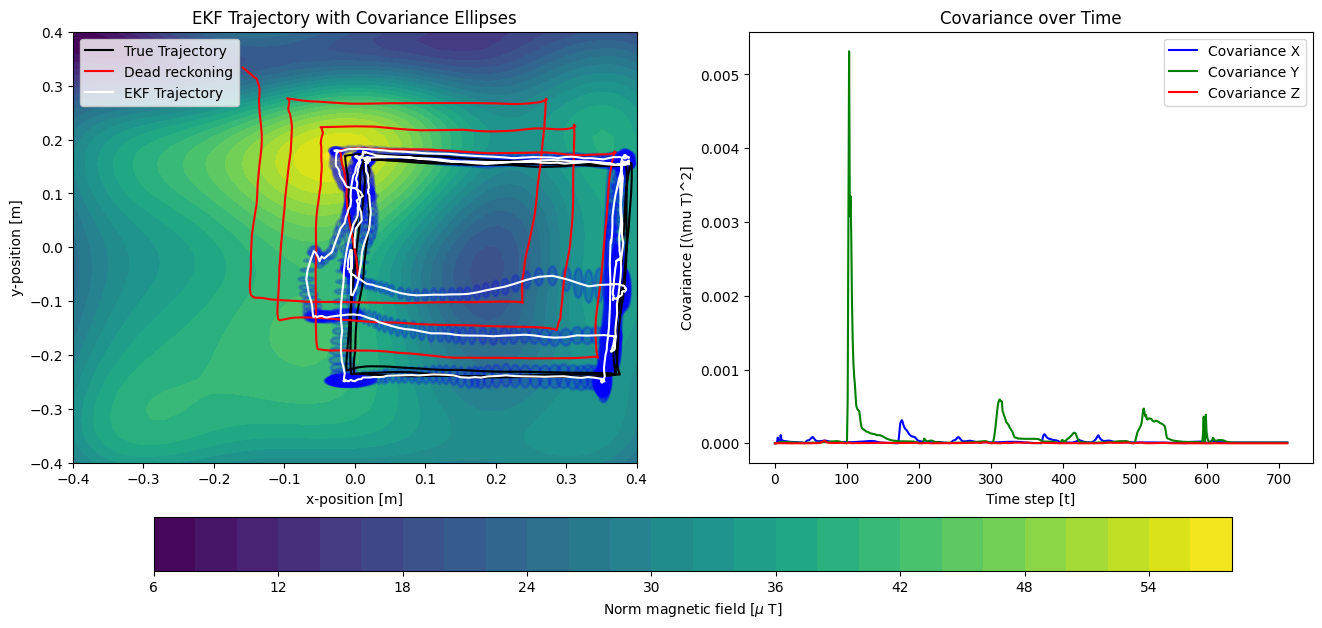

In [8]:
''' DO NOT CHANGE THE CODE BELOW '''
helper.makeExtendedKalmanFilterPlots(deadReckoning, posEstEKF, posCovarianceEKF, modelParameters)

**Discussion**

Explain why the covariance changes over time the way it does. You can create more plots if necessary for your analysis.

### UKF implement 

#### Task 1
Fill in the `dynamicUpdateUKF()` function according to the dynamic model given above. 

#### Note:
You do not have to change the inputs and outputs to the given functions.


In [9]:
def dynamicUpdateUKF(position, 
                   deltaPos, 
                   posCov, 
                   motionCovarianceUKF, 
                   modelParameters):
    ''' Dynamic update '''
    # Note we can just use the same update as with the EKF, thus below is the exact same. This is because the UKF is just an approximation of the actual distribution. If the actual distribution
    # is in fact Gaussian, why would we use sigma points?
    gWhiteNoise = np.random.multivariate_normal(mean=np.zeros(3), cov=motionCovarianceUKF).T
    gWhiteNoise = np.reshape(gWhiteNoise,(3,1))
    # Define our new position as the former position, plus the delta position, plus the white noise
    position = position + deltaPos + gWhiteNoise

    # Define our F matrix by calculating the relative change in position caused by deltaPos, since each diagonal entry of F is just 1 + dx/x. Note that we assume there are no cross-terms
    relativeGain = deltaPos/position
    F = np.zeros((3,3))
    for i in range(3):
        F[i,i] = 1 + relativeGain[i].item()  

    # Define the covariance in accordance with the classic time update of the Kalman Filter
    posCov = F@posCov@F.T + motionCovarianceUKF

    return position, posCov

#### Task 2

- Complete creating sigma points `createSigmaPoints()` and calculating sigma weights `calculateSigmaWeights()`.
- Fill in the `measurementUpdateUKF()` according to the measurement model given above. 
- You can play around with UT1 and UT2, can you see any obvious differences?


In [ ]:
def createSigmaPoints(stateVector, 
                      stateCovariance, 
                      lamdaWeights,
                      modelParameters):
    ''' Create sigma points '''
    # First define the size of our state vector n as 3
    n = 3
    # Then calculate the square root of the covariance. We do this by taking the SVD (since the covariance is positive definite, the S matrix will correspond to the eigenvalues)
    # Then since U is an orthogonal matrix, by taking the square root of S and surrounding it with U and Ut, U*sqrtS*Ut*U*sqrtS*Ut = U*S*Ut = P
    U, S, Ut = np.linalg.svd(stateCovariance)
    sqrtS = np.diag(np.sqrt(S))
    sqrtP = U@sqrtS@Ut
    # Define our sigma points as array size 3 by 2n+1 (each point has three coordinates and we have 2n+1 points)
    sigmaPoints = np.zeros((n,2*n+1))
    sigmaPoints[:,0] = stateVector.flatten()
    for i in range(1,n):
        sigmaPoints[:,i] = stateVector.flatten() + np.sqrt(n+lamdaWeights)*sqrtP[:,i].flatten()
        sigmaPoints[:,i+n] = stateVector.flatten() - np.sqrt(n+lamdaWeights)*sqrtP[:,i].flatten()
    return sigmaPoints


def calculateSigmaWeights(UTnumber = 1):
    ''' Calculate the weights '''
    n = 3
    if UTnumber == 1:
        '''UT1'''
        # Calculate UT1. Note that we are writing it out for clarity and to compare with UT2
        alpha = np.sqrt(3/n)
        kappa = 0
        beta = 3/(n-1)
        lamdaWeights = (alpha**2)*(n+kappa)-n
    else:
        '''UT2'''
        # Calculate UT2
        alpha = 10**(-3)
        kappa = 0
        beta = 2
        lamdaWeights = (alpha**2)*(n+kappa)-n

    # Define the size of weights, and then the weights according to the formula in the slides
    weightsMean = np.zeros(2*n+1)
    weightsCov = np.zeros(2*n+1)
    weightsMean[0] = lamdaWeights/(n+lamdaWeights)
    weightsCov[0] = weightsMean[0] + (1-alpha**2+beta)

    for i in range(1,2*n+1):
        weightsMean[i] = 1/(2*(n+lamdaWeights))
        weightsCov[i] = 1/(2*(n+lamdaWeights))
    return lamdaWeights, weightsMean, weightsCov


def measurementUpdateUKF(position,
                         magnetometerMeasurement,
                         posCovariance,
                         measurementCovarianceUKF,
                         lamdaWeights, 
                         weightsMean, 
                         weightsCovariance,
                         modelParameters):
    
    ''' Measurement update '''
    # First define the size of our state vector
    n=3

    # Then we define the sigma points via our premade function
    sigmaPoints = createSigmaPoints(position,posCovariance,lamdaWeights,modelParameters)

    # Then push the points through the measurement prediction function
    ySigma = np.zeros((3,2*n+1))
    for i in range(2*n+1):
        ySigma[i] = GP.makeMagneticFieldPrediction(sigmaPoints[:,i], modelParameters)
    
    # Then, our final prediction mean is equal to the weighted average of these points
    measurementMean = 0
    for i in range(2*n+1):
        measurementMean = measurementMean + weightsMean[i]*ySigma[:,i]

    # And our measurement covariance is equal to the weighted average of all covariances
    
    measurementCovariance = np.zeros((3,3))
    for i in range(2*n+1):
        measurementCovariance = measurementCovariance + weightsMean[i]*(ySigma[:,i] - measurementMean)@(ySigma[:,i] - measurementMean).T

    CrossCov = 0
    for i in range(2*n+1):
        CrossCov = CrossCov + weightsMean[i]*(sigmaPoints[:,i] - position)@(ySigma[:,i] - measurementMean).T

    KalmanGain = CrossCov/measurementCovariance
    position = position + KalmanGain*(magnetometerMeasurement - measurementMean)
    posCovariance = posCovariance - KalmanGain@measurementCovariance@KalmanGain.T
    return position, posCovariance

`unscentedKalmanFilter()` is given as follows. You don't need to change it.

In [11]:
''' DO NOT CHANGE THE CODE BELOW '''
def unscentedKalmanFilter(position, 
                          deltaPos, 
                          magnetometerMeasurement, 
                          posCovariance, 
                          motionCovarianceUKF,
                          measurementCovarianceUKF,
                          lamdaWeights, 
                          weightsMean, 
                          weightsCovariance,
                          modelParameters):

    if modelParameters['NtimeStepUKF'] > 0:
        ''' State update '''
        position, posCovariance = dynamicUpdateUKF(position, 
                                                deltaPos, 
                                                posCovariance, 
                                                motionCovarianceUKF, 
                                                modelParameters)

    ''' Measurement update '''
    position, posCovariance = measurementUpdateUKF(position, 
                                                   magnetometerMeasurement, 
                                                   posCovariance, 
                                                   measurementCovarianceUKF,
                                                   lamdaWeights,
                                                   weightsMean,
                                                   weightsCovariance,
                                                   modelParameters)

    return position, posCovariance



#### Task 3

Be sure to set the **initial position** and the **prior** on it correctly  and a **suitable measurement covariance** as you did in assignment 1.

You could start with the following parameters
- `motionCovarianceUKF` = np.eye(3)*0.001**2 
- `measurementCovarianceUKF` = np.eye(3)*1.5**2

Make sure `posCovarianceUKF` is a 3d tensor with the shape of `[3,3,NtimeSteps]`, to save the position covariances for every time step.
To get better results, you might have to tune these. 

In [12]:

''' Initialize the UKF '''
modelParameters['NtimeStepUKF'] = 0


motionCovarianceUKF = np.eye(3)*0.001**2
measurementCovarianceUKF = np.eye(3)*1.5**2

posEstUKF = np.zeros((3,modelParameters['NtimeSteps']))
posCovarianceUKF = np.zeros((3,3,modelParameters['NtimeSteps']))

lamdaWeights, weightsMean, weightsCovariance = calculateSigmaWeights()
''' Run the UKF'''
for timendx in range(modelParameters['NtimeSteps']-1):
    (posEstUKF[:, timendx+1:timendx+2], 
     posCovarianceUKF[:, :, timendx+1]) = unscentedKalmanFilter(posEstUKF[:, timendx:timendx+1], 
                                               deltaMagnetometerPositions[:, timendx:timendx+1], 
                                               magnetometerMeasurements[:, timendx:timendx+1], 
                                               posCovarianceUKF[:, :, timendx],
                                               motionCovarianceUKF,
                                               measurementCovarianceUKF,
                                               lamdaWeights, 
                                               weightsMean, 
                                               weightsCovariance,
                                               modelParameters)
    modelParameters['NtimeStepUKF'] += 1



posCovarianceEKF = np.zeros((3, 3, modelParameters['NtimeSteps']))
posCovarianceEKF[:,:,0] = np.eye(3)*0


Error: Input should be a 3xN matrix


IndexError: tuple index out of range

#### discussion

Elaborate on the effects of tuning the different variables:

- `motionCovarianceUKF`
- `measurementCovarianceUKF`
- The initial posiiton covariance `posCovarianceUKF[:, :, 0]`

Is it different from tuning the variables for the EKF?

### compare EKF and UKF
#### Visualize the output

In [ ]:
helper.makeKalmanFilterPlots(deadReckoning, posEstEKF, posEstUKF, modelParameters)

#### Discussion
Elaborate on the two plots.
- Compare the results from the UKF with the EKF? Does one provide better results? Elaborate!
- Comment on the reason for choosing either EKF, UKF of PF for this non-linear estimation problem. Also relate this to the results from assignment 1. 
- In what type of estimation problems would you expect to see very different results for the EKF, UKF and PF? 


<!-- TODO: DO WE NEED THE "PLAY AROUND WITH DIFFERENT PARAMETERS SESSION AS THE FIRST ASSIGMENT?" -->